In [76]:
from collections import Counter

import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sb

# Bagging
1. boostrapped aggregation

## Bootstrapping

1. First, we create random samples of the training data set with replacment (we *aren't creating new samples*, we are rather bucketing samples from the main training dataset into smaller subsets).
    
    1. the likelihood of the models in the ensemble being exposed to truly distinct sets depends on sampling with replacement or without replacement
    2. with replacement([`bootstrap=True`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)) shall be typically used when the dataset size is small enough s.t. not all base estimators will get at least K-sized subset.
    3. without replacement shall be typically used when the dataset size is large enough s.t. all base estimators will get at least a K-sized subset.
    4. when **subsets** are **created without replacement**, the process is called **subsetting instead of bootstrapping**.

2. Then, we build a model (classifier or Decision tree) for each sample. 

3. **Bootstrapping**: [mathematical derivation](https://chatgpt.com/share/679a8031-51ac-800d-9b2e-1684dc16d057) of OOB ratio(~37%) and bootstrapped-samples ratio(~63%)

## Aggregation

1. **Aggregation**: Finally, results of these multiple models are combined using average or majority voting.

## How Bagging = Bootstrapping + Aggregation?

1. As each model is exposed to a **different subset of data**
    1. this results in diverse models being created.
    2. diversity results from them being trained on slightly different subsets of the original dataset. 
    3. If you were to train all the base models on the exact same dataset, they’ll make the same mistakes, and their errors will be perfectly correlated. 
    4. Bagging works because each model is forced to overfit to different pieces of the data, and therefore *makes different mistakes*.
2. Diversity is what sets bagging apart from an individual classical ML model
    1. Bagging prefers usage of low bias high variance models as its base estimators, like decision trees.
    2. if say a single DT was used for modelling the problem, it will fundamentally overfit.
    3. In bagging rather, the aggregation step is what leads to an overall lower variance
        1. since each base DT is trained with a different subset of samples, each will be a low bias high variance model.
        2. however, for a given test sample, the noise picked by each of the base DTs will be uncorrelated as each of these DTs has *theoretically learnt different patterns*.
    1. Thus, Bagging helps us to reduce the variance error.
3. Combinations of multiple models decreases variance, especially in the case of unstable models, and may produce a more reliable prediction than a single model.
4. <font color="red">Note:</font> If the **dataset** is **too small**, **bootstrapping** can lead to **highly overlapping trees**, reducing the benefit of ensembling.
    - this is because the weak learners will receive overlapping datasets themselves, thus the entire idea of creating **uncorrelated decision trees** (the very principle of bagging) will be defeated.

## Feature importance
1. since the underlying estimator could be anything, it by itself doesn't have any feature importance calculation method/function(even in sklearn)
2. a crude way would be to calculate the feature importance for each base estimator and then take an average across all estimators for each feature.
3. 

# Bagging as seen in sklearn - Classifier

In [63]:
# initialise classification dataset
X, y = make_classification(n_samples=1000, n_features=10, n_classes=3, n_informative=3,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=100,
    bootstrap=True, # usage of Bagging, for pasting change this to False
    n_jobs=2,
    random_state=42
)
bag_clf.fit(X_train, y_train)

y_pred_bag_clf = bag_clf.predict(X_test)
print(classification_report(y_test, y_pred_bag_clf))

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

y_pred_dt_clf = dt_clf.predict(X_test)

print(classification_report(y_test, y_pred_dt_clf))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        86
           1       0.83      0.76      0.79        82
           2       0.79      0.88      0.83        82

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.83      0.83      0.83       250

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        86
           1       0.80      0.84      0.82        82
           2       0.81      0.83      0.82        82

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250



In [ ]:
# lets see how the individual estimators fare against the trained decision tree
# compare the base estimators' performance with the fully-grown isolated decision tree

# Get predictions from each base model
base_model_preds = [model.predict(X_test) for model in bag_clf.estimators_]

base_model_precisions = [precision_score(y_test, base_model_pred, average=None) for base_model_pred in base_model_preds]
base_model_recalls = [recall_score(y_test, base_model_pred, average=None) for base_model_pred in base_model_preds]
base_model_f1s = [f1_score(y_test, base_model_pred, average=None) for base_model_pred in base_model_preds]

dt_clf_precision = precision_score(y_test, y_pred_dt_clf, average=None)
dt_clf_recall = recall_score(y_test, y_pred_dt_clf, average=None)
dt_clf_f1 = f1_score(y_test, y_pred_dt_clf, average=None)

print(Counter((dt_clf_precision > base_model_precisions).all(axis=1)))
print(Counter((dt_clf_recall > base_model_recalls).all(axis=1)))
print(Counter((dt_clf_f1 > base_model_f1s).all(axis=1)))

Counter({True: 84, False: 16})
Counter({True: 66, False: 34})
Counter({True: 91, False: 9})


So we see that:
- out of the 100 base estimators, only 16 were as precise or even more precise than the full depth decision tree
- out of the 100 base estimators, only 34 had as high a recall or even more than the full depth decision tree
- out of the 100 base estimators, only 9 had as high an f1-score or even more than the full depth decision tree

## Check if Bagging actually works in practice - Classifier
- check if the claim of bootstrapping, that the underlying base estimators produce uncorrelated errors is true practically:
- The correlation matrix will give you the correlation between the residuals of each pair of base models. 
- If bagging is working as expected, these values should be low, ideally close to 0.
- MSE of each base model will show if they’re performing similarly or if their individual biases vary. 
    - If the errors are correlated, their MSEs should be roughly the same, and vice versa.

No significant correlation detected between the errors of the base models.


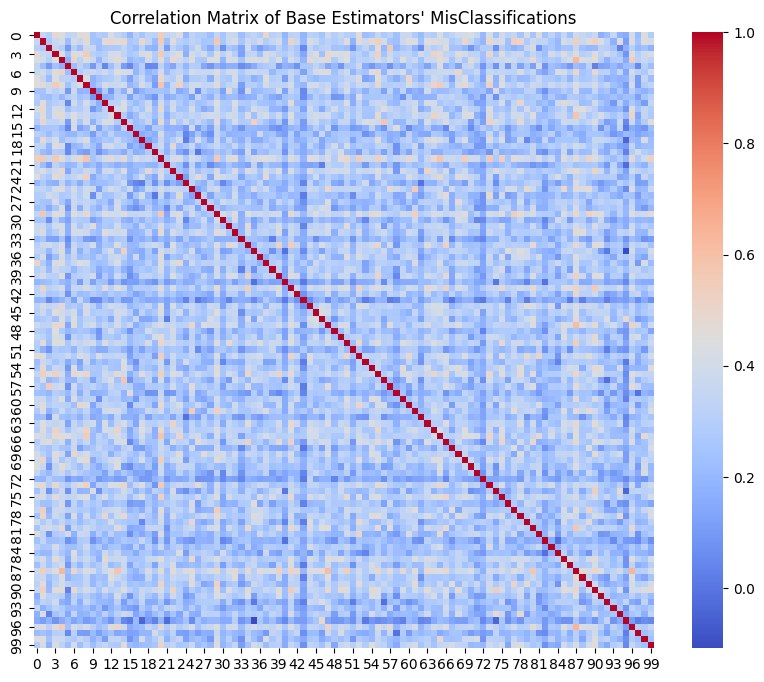

In [ ]:
###################### Classification task ######################
# Compute misclassification residuals (1 if wrong, 0 if correct)

y_true_broadcasted_per_estimator = np.tile(y_test, (bag_clf.n_estimators,1))

misclassifications = (base_model_preds != y_true_broadcasted_per_estimator).astype(int)

# Calculate the correlation matrix of the misclassifications
correlation_matrix = np.corrcoef(misclassifications)


#################  AUTOMATED EVALUATION OF CORRELATION MATRIX ############################
#################  WHEN NO. OF ESTIMATORS IS TOO HIGH ####################################
# Find the pairwise correlations that are too high (above some threshold, e.g., 0.9)
high_correlation_pairs = np.where(np.abs(correlation_matrix) > 0.9)
high_correlation_pairs = [(i, j) for i, j in zip(*high_correlation_pairs) if i < j]

# Output the problematic pairs of base models
if high_correlation_pairs:
    print("Found high correlation between the following base model pairs (indices):")
    for pair in high_correlation_pairs:
        print(pair)
else:
    print("No significant correlation detected between the errors of the base models.")

plt.figure(figsize=(10, 8))
sb.heatmap(data=correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Base Estimators' MisClassifications")
plt.show()

In [22]:
print([len(x) for x in bag_clf.estimators_samples_])

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


## Use `max_samples = n_samples`

In [23]:
# if max_samples is not used
bag_clf_2 = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    bootstrap=True, # usage of Bagging, for pasting change this to False
    n_jobs=2,
    random_state=42
)
bag_clf_2.fit(X_train, y_train)
print([len(x) for x in bag_clf_2.estimators_samples_])

[750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750]


So, it is really all samples are being used in the bagging classifier.\
Lets check its classification report

In [24]:
y_pred_bag_clf_2 = bag_clf_2.predict(X_test)
print(classification_report(y_test, y_pred_bag_clf_2))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        86
           1       0.86      0.85      0.86        82
           2       0.83      0.88      0.85        82

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250



Hmm... Strange.\
It did suprisingly better than the bagging model with only 100 samples per estimator\
Could be because of the 750 samples having a better signal than only 100 samples\
But let's see how correlated are the base estimators

Found high correlation between the following base model pairs (indices):
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 25)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 38)
(0, 39)
(0, 40)
(0, 41)
(0, 42)
(0, 43)
(0, 44)
(0, 45)
(0, 46)
(0, 47)
(0, 48)
(0, 49)
(0, 50)
(0, 51)
(0, 52)
(0, 53)
(0, 54)
(0, 55)
(0, 56)
(0, 57)
(0, 58)
(0, 59)
(0, 60)
(0, 61)
(0, 62)
(0, 63)
(0, 64)
(0, 65)
(0, 66)
(0, 67)
(0, 68)
(0, 69)
(0, 70)
(0, 71)
(0, 72)
(0, 73)
(0, 74)
(0, 75)
(0, 76)
(0, 77)
(0, 78)
(0, 79)
(0, 80)
(0, 81)
(0, 82)
(0, 83)
(0, 84)
(0, 85)
(0, 86)
(0, 87)
(0, 88)
(0, 89)
(0, 90)
(0, 91)
(0, 92)
(0, 93)
(0, 94)
(0, 95)
(0, 96)
(0, 97)
(0, 98)
(0, 99)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)


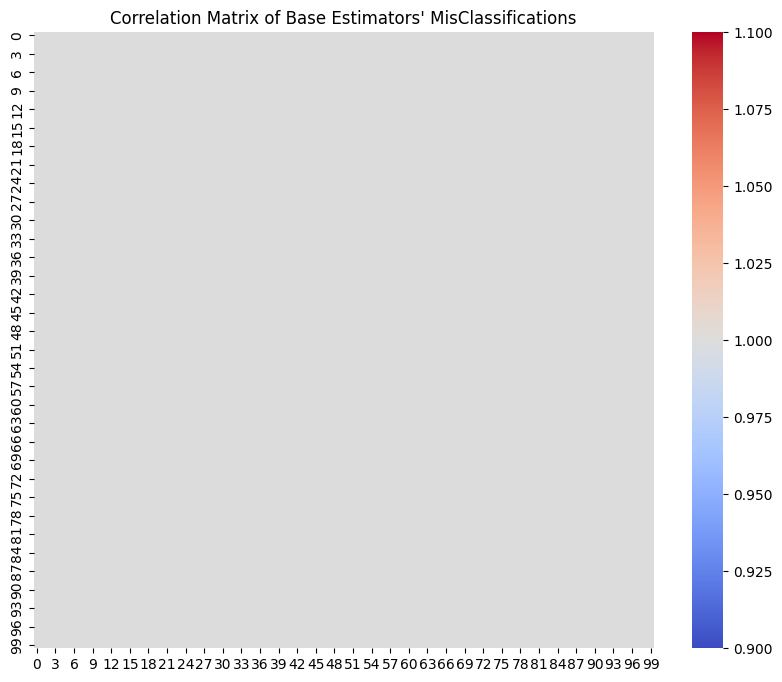

In [25]:
###################### Classification task ######################
# Compute misclassification residuals (1 if wrong, 0 if correct)

y_true_broadcasted_per_estimator = np.tile(y_test, (bag_clf_2.n_estimators,1))
base_model_preds_clf_2 = bag_clf_2.predict(X_test)
misclassifications = (base_model_preds_clf_2 != y_true_broadcasted_per_estimator).astype(int)

# Calculate the correlation matrix of the misclassifications
correlation_matrix = np.corrcoef(misclassifications)


#################  AUTOMATED EVALUATION OF CORRELATION MATRIX ############################
#################  WHEN NO. OF ESTIMATORS IS TOO HIGH ####################################
# Find the pairwise correlations that are too high (above some threshold, e.g., 0.9)
high_correlation_pairs = np.where(np.abs(correlation_matrix) > 0.9)
high_correlation_pairs = [(i, j) for i, j in zip(*high_correlation_pairs) if i < j]

# Output the problematic pairs of base models
if high_correlation_pairs:
    print("Found high correlation between the following base model pairs (indices):")
    for pair in high_correlation_pairs:
        print(pair)
else:
    print("No significant correlation detected between the errors of the base models.")

plt.figure(figsize=(10, 8))
sb.heatmap(data=correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Base Estimators' MisClassifications")
plt.show()

- There's the problem we were suspecting.
- All estimators are highly correlated, because they are essentially the same decision tree config exposed to the same dataset, thus making them all identical
- this is strange, considering the isolated model is also theoretically the same model, but it didn't have the same level of performance
- let's see the performance of individual estimators

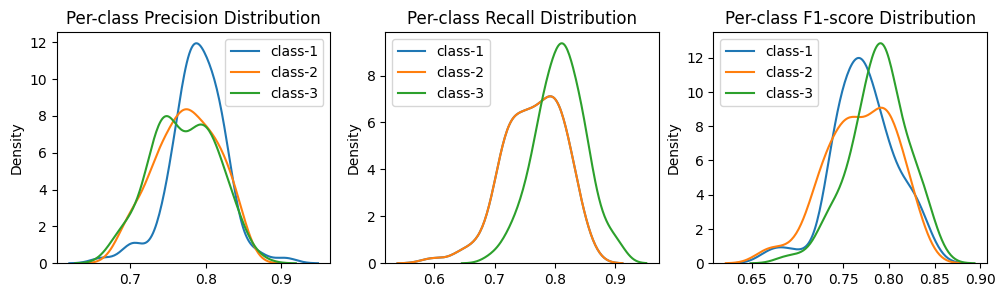

In [33]:
# Get predictions from each base model
base_model_preds = [model.predict(X_test) for model in bag_clf_2.estimators_]

base_model_precisions = np.array([precision_score(y_test, base_model_pred, average=None) for base_model_pred in base_model_preds])
base_model_recalls = np.array([recall_score(y_test, base_model_pred, average=None) for base_model_pred in base_model_preds])
base_model_f1s = np.array([f1_score(y_test, base_model_pred, average=None) for base_model_pred in base_model_preds])


fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sb.kdeplot(base_model_precisions[:, 0], label='class-1', ax=ax[0]);sb.kdeplot(base_model_precisions[:, 1], label='class-2', ax=ax[0]);sb.kdeplot(base_model_precisions[:, 2], label='class-3', ax=ax[0])
sb.kdeplot(base_model_recalls[:, 1], label='class-1', ax=ax[1]);sb.kdeplot(base_model_recalls[:, 1], label='class-2', ax=ax[1]);sb.kdeplot(base_model_recalls[:, 2], label='class-3', ax=ax[1])
sb.kdeplot(base_model_f1s[:, 0], label='class-1', ax=ax[2]);sb.kdeplot(base_model_f1s[:, 1], label='class-2', ax=ax[2]);sb.kdeplot(base_model_f1s[:, 2], label='class-3', ax=ax[2])

ax[0].legend();ax[1].legend();ax[2].legend()
ax[0].set_title('Per-class Precision Distribution');ax[1].set_title('Per-class Recall Distribution');ax[2].set_title('Per-class F1-score Distribution')
plt.show()

## Check OOB Score
- out of bagging score
- when max_samples is initialised s.t. `max_samples != n_samples`, the samples that didn't end up being used in the bootstrap sample-set for each base estimator will be termed as out of bag samples
    - each base estimator will have a set of samples that it didn't use while it was being trained.
        - this set of samples = out of bag samples
        - important because they can be used to estimate the model's generalization performance without needing a separate validation set.
    - out of bagging samples, as they weren't considered during bootstrapping, hence weren't used in aggregation as well

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=100,
    bootstrap=True, # usage of Bagging, for pasting change this to False
    n_jobs=2,
    oob_score=True,
    random_state=42
)
bag_clf.fit(X_train, y_train)

print(f"OOB Score = {round(bag_clf.oob_score_, 3)}\n")

y_pred_bag_clf = bag_clf.predict(X_test)
print(classification_report(y_test, y_pred_bag_clf))

OOB Score = 0.817

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        86
           1       0.83      0.76      0.79        82
           2       0.79      0.88      0.83        82

    accuracy                           0.83       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.83      0.83      0.83       250



In [40]:
print(bag_clf.n_features_in_, bag_clf.estimators_features_)

10 [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4,

Print the class probabilities for each sample in the OOB set

In [41]:
print(bag_clf.oob_decision_function_)

[[0.14942529 0.09195402 0.75862069]
 [0.94047619 0.01190476 0.04761905]
 [0.05555556 0.87777778 0.06666667]
 ...
 [0.84444444 0.13333333 0.02222222]
 [0.49411765 0.35294118 0.15294118]
 [0.27586207 0.49425287 0.22988506]]


`BaggingClassifier` automatically performs **soft voting** if the classifier can calculate the probabilities for its predictions(`predict_proba()` method)

Bagging is much better than Pasting

* When performing Bagging on a training set, only 63% of the instances are included in the model, that means there are 37% of the instances that the classifier has not seen before. 
    * These can be used for evaluation just like Cross-Validation.
    
    * To use this functionality, simply add a `oob_score = True` parameter in the `BaggingClassifier` 

# BaggingRegressor

In [67]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, noise=0.4, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [68]:
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(),
    n_estimators=100,
    max_samples=100,
    bootstrap=True, # usage of Bagging, for pasting change this to False
    n_jobs=2,
    oob_score=True,
    random_state=42
)
bag_reg.fit(x_train, y_train)

# Print the predicted value for each sample in the OOB set
print(bag_reg.oob_score_)
print(bag_reg.oob_prediction_.shape, "\n\n", bag_reg.oob_prediction_)

0.9124870880463712
(750,) 

 [  28.76751086  -56.95204855   87.05461874  -82.75458394  -51.08932431
   54.9687305    75.40746977   82.28596613   47.10120261   26.19376495
   70.58675263   -1.95221036  -30.89477758  -10.32388706  -23.23694367
 -108.37920109  -20.03694739  -97.80295269   19.27133242  -65.2406354
  -30.47402689    5.75007538  -36.99869046   55.7957313    46.83356974
  -87.08692494  -42.23991597   62.53955713   68.53079401   94.85724278
  -94.17594895  -64.63154085  -80.60633747   25.75957851  -48.72597202
  -22.1053971   -91.5984888    63.60952277  -47.72338967   56.83141371
  -35.2528469    16.14521259   67.15436152 -105.00074883   23.85286018
   14.82662367   72.7738169   -42.866593    -42.63244764  -57.58162873
   13.97162617   44.61069535    6.40655053  -55.65034442   35.00283723
   34.05400111 -126.13521785  -65.78326114 -105.8373369   -20.26886105
  -57.65810599   19.70402567   31.52786686  -44.59633328  -35.43144514
    0.15394938  115.52496975   41.66115959   60.8

## Check if Bagging actually works in practice
- check if the claim of bootstrapping, that the underlying base estimators produce uncorrelated errors is true practically:
- The correlation matrix will give you the correlation between the residuals of each pair of base models. 
- If bagging is working as expected, these values should be low, ideally close to 0.
- MSE of each base model will show if they’re performing similarly or if their individual biases vary. 
    - If the errors are correlated, their MSEs should be roughly the same, and vice versa.

Correlation matrix of residuals between base models:
 [[1.         0.16622886 0.32614876 ... 0.19583632 0.23065888 0.16061761]
 [0.16622886 1.         0.43712193 ... 0.41620587 0.32313647 0.17904506]
 [0.32614876 0.43712193 1.         ... 0.30235722 0.31117354 0.22657682]
 ...
 [0.19583632 0.41620587 0.30235722 ... 1.         0.33700251 0.1177392 ]
 [0.23065888 0.32313647 0.31117354 ... 0.33700251 1.         0.38123081]
 [0.16061761 0.17904506 0.22657682 ... 0.1177392  0.38123081 1.        ]]
Mean Squared Errors for each base model:  [1969.1966701  1397.11913863  835.66706059 1242.89043461  934.48761013
 1242.76603973 1686.80083937 2163.63013763 1047.15092428 1215.96051409
 1057.54349924 1285.25772475 1321.35778284 1465.8069702  1135.30816081
 1038.13423115 1672.82733995 1032.47113958 1076.31275958 1524.19960083
 1121.99561719 1666.77683164 1294.1540793  1180.01576511 1534.72885233
 1899.44587585 1327.57245618 1408.5767791  1316.21989767 1188.88254061
 1590.98152359 1624.05537996 2228.

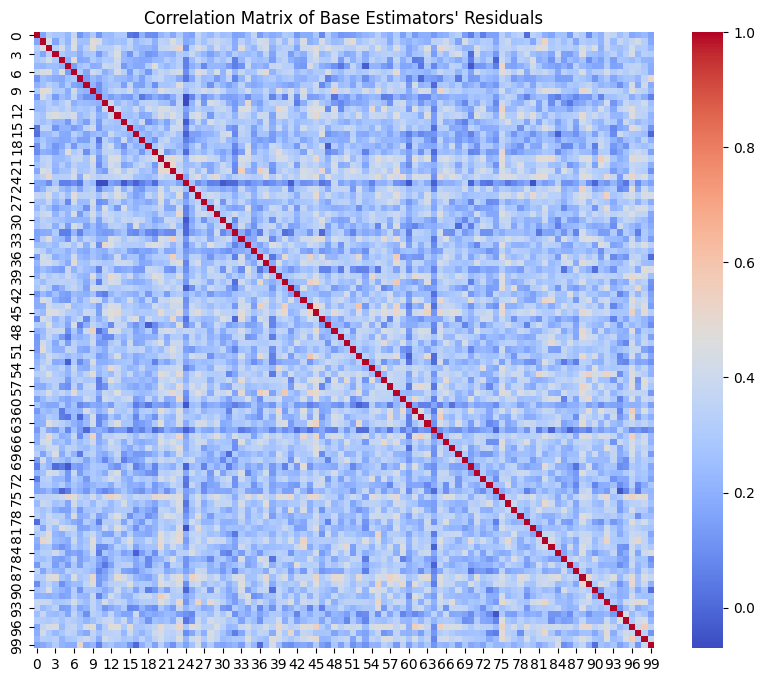

In [69]:
# Get predictions from each base model
base_model_preds = np.array([model.predict(x_test) for model in bag_reg.estimators_])


###################### Regression task ######################
# Compute residuals (errors)
residuals = base_model_preds - y_test

# Calculate the correlation matrix of the residuals
correlation_matrix = np.corrcoef(residuals)

# Print the correlation matrix (it's the key here)
print("Correlation matrix of residuals between base models:\n", correlation_matrix)

# Optionally, you can also calculate the mean squared error for each base model to see performance differences
errors = np.array([mean_squared_error(y_test, preds) for preds in base_model_preds])
print("Mean Squared Errors for each base model: ", errors)

#################  AUTOMATED EVALUATION OF CORRELATION MATRIX ############################
#################  WHEN NO. OF ESTIMATORS IS TOO HIGH ####################################
# Find the pairwise correlations that are too high (above some threshold, e.g., 0.9)
high_correlation_pairs = np.where(np.abs(correlation_matrix) > 0.9)
high_correlation_pairs = [(i, j) for i, j in zip(*high_correlation_pairs) if i < j]

# Output the problematic pairs of base models
if high_correlation_pairs:
    print("Found high correlation between the following base model pairs (indices):")
    for pair in high_correlation_pairs:
        print(pair)
else:
    print("No significant correlation detected between the errors of the base models.")

plt.figure(figsize=(10, 8))
sb.heatmap(data=correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Base Estimators' Residuals")
plt.show()

# Random patches and random subspaces

1. All ensemble techniques up until now sampled only the training instances, but kept all the features(`bootstrap_features = False`).

2. Random Patches: samples both training instances and features(out of d features, k are chosen at random, just as how training instances were chosen at random)

3. Random Subspaces: keeps all the instances but samples features.

In [72]:
subspaceBagReg = BaggingRegressor(
    DecisionTreeRegressor(random_state=42),
    n_estimators=500,
    max_samples=0.6,
    bootstrap=True, # usage of Bagging, for pasting change this to False
    n_jobs=2,
    random_state=42,
    oob_score=True,
    bootstrap_features=True
)

patchedBagReg = BaggingRegressor(
    DecisionTreeRegressor(random_state=42),
    n_estimators=500,
    max_samples=0.6,
    bootstrap=True, # usage of Bagging, for pasting change this to False
    n_jobs=2,
    random_state=42,
    oob_score=True,
    bootstrap_features=True,
    max_features=0.6
)

patchedBagReg.fit(x_train, y_train)
subspaceBagReg.fit(x_train, y_train)

print(subspaceBagReg.oob_score_, patchedBagReg.oob_score_)

print(mean_squared_error(y_test, subspaceBagReg.predict(x_test)), mean_squared_error(y_test, patchedBagReg.predict(x_test)))

0.8202863075522266 0.6662509218658053
690.2218730699373 1309.2362264335538


In [74]:
print(subspaceBagReg.estimators_features_)

[array([9, 2, 9, 7, 7, 8, 3, 2, 8, 9]), array([7, 3, 7, 3, 9, 5, 3, 9, 0, 3]), array([6, 0, 7, 7, 9, 8, 5, 8, 2, 5]), array([0, 5, 7, 4, 1, 3, 6, 2, 5, 3]), array([6, 9, 6, 3, 3, 8, 3, 7, 8, 6]), array([5, 2, 1, 2, 7, 9, 3, 1, 3, 6]), array([3, 2, 1, 5, 2, 3, 1, 5, 5, 1]), array([6, 2, 8, 2, 5, 9, 0, 4, 3, 5]), array([8, 4, 4, 3, 2, 3, 6, 8, 3, 7]), array([8, 1, 8, 9, 0, 7, 6, 8, 1, 1]), array([3, 2, 9, 8, 4, 6, 6, 3, 4, 2]), array([4, 7, 8, 6, 7, 1, 9, 7, 2, 8]), array([3, 9, 4, 8, 6, 1, 5, 2, 4, 3]), array([0, 9, 6, 7, 4, 0, 5, 9, 9, 5]), array([0, 8, 2, 0, 2, 6, 0, 3, 4, 1]), array([8, 4, 6, 6, 8, 1, 6, 3, 0, 5]), array([7, 7, 2, 0, 3, 7, 5, 8, 5, 3]), array([8, 4, 2, 8, 1, 4, 6, 6, 2, 4]), array([7, 4, 2, 8, 6, 8, 6, 4, 5, 5]), array([8, 1, 5, 0, 2, 7, 6, 0, 9, 0]), array([5, 8, 8, 3, 0, 5, 3, 2, 1, 5]), array([4, 6, 2, 7, 7, 8, 5, 7, 0, 3]), array([1, 5, 2, 7, 1, 7, 8, 0, 8, 6]), array([8, 8, 6, 9, 9, 2, 9, 9, 4, 0]), array([1, 4, 2, 3, 7, 3, 1, 9, 2, 8]), array([4, 1, 3, 1, 4, 1,

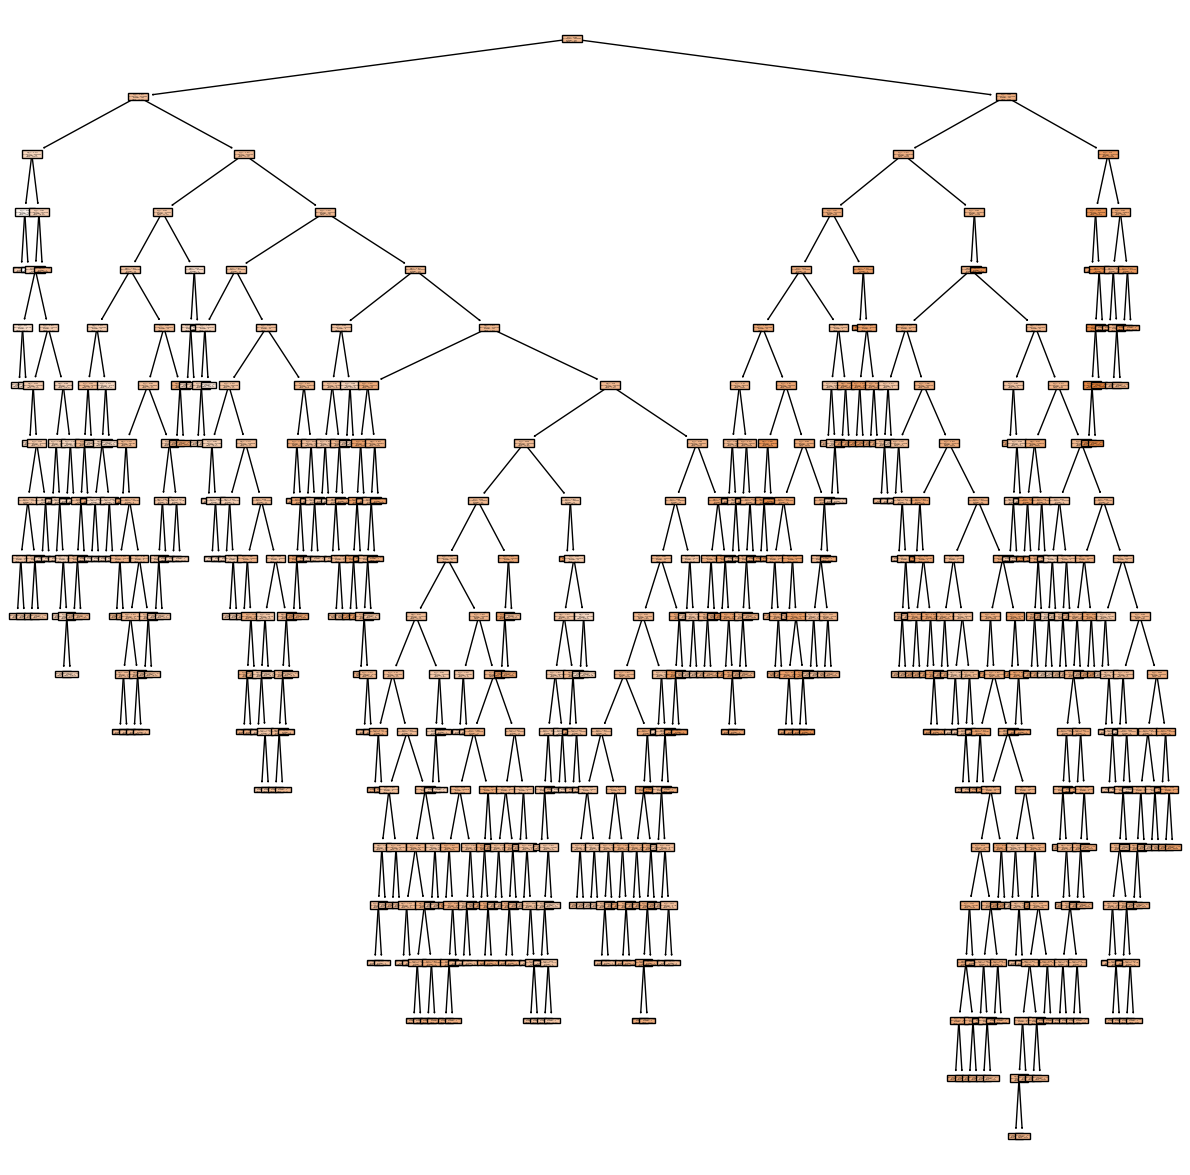

In [77]:
plt.figure(figsize=(15, 15))
tree.plot_tree(subspaceBagReg.estimators_[0], filled=True)
plt.show()